In [5]:
# ================== CẤU HÌNH ĐƯỜNG DẪN ==================
DATASET_DIR = 'dataset/data_full_clean.csv'
SAVE_EMBEDDINGS_DIR = 'models/embeddings_train_test'
SAVE_MODEL_DIR = 'models/svm'


In [3]:
# ================== EMBEDDING DATA INPUT  ==================
from phobert_svm_pipeline import prepare_and_save_embeddings

prepare_and_save_embeddings(
    DATASET_DIR,
    title_col='title',
    content_col='description',
    label_col='label',
    save_dir=SAVE_EMBEDDINGS_DIR
)

>> Embedding train set...
>> Embedding test set...
>> Saved embeddings (.npy) to models/embeddings_train_test
>> Train: (37698, 768), Test: (9425, 768)


In [3]:
import numpy as np
import joblib
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# =========================
# 1️⃣ Load dữ liệu
# =========================

X_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_train.npy")

X_test = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_test_emb.npy")
y_test = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_test.npy")
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# =========================
# 2️⃣ Pipeline: Scaling + LinearSVC
# =========================
clf = Pipeline([
    ("scaler", StandardScaler()),  # rất quan trọng cho SVM
    ("svm", LinearSVC(
        C=1.0,
        class_weight="balanced",  # nên bật nếu data lệch lớp
        random_state=42
    ))
])

# =========================
# 3️⃣ Train
# =========================
print(">> Training LinearSVC...")
clf.fit(X_train, y_train)

# =========================
# 4️⃣ Evaluate
# =========================
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy : {acc:.4f}")
print(f"F1-macro : {f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# =========================
# 5️⃣ Save model
# =========================
joblib.dump(clf, f"{SAVE_MODEL_DIR}/linear_svc_phobert.joblib")
print(">> Model saved to linear_svc_phobert.joblib")


Train shape: (37698, 768)
Test shape : (9425, 768)
>> Training LinearSVC...
Accuracy : 0.8637
F1-macro : 0.8635

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       730
           1       0.79      0.78      0.79       716
           2       0.85      0.86      0.85       714
           3       0.94      0.92      0.93       734
           4       0.81      0.82      0.82       733
           5       0.85      0.85      0.85       710
           6       0.95      0.96      0.95       735
           7       0.80      0.85      0.82       714
           8       0.86      0.85      0.86       733
           9       0.97      0.96      0.97       726
          10       0.79      0.78      0.79       731
          11       0.93      0.94      0.94       721
          12       0.77      0.76      0.76       728

    accuracy                           0.86      9425
   macro avg       0.86      0.86      0.86      942

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>> Loading PhoBERT from local: models/phobert-base


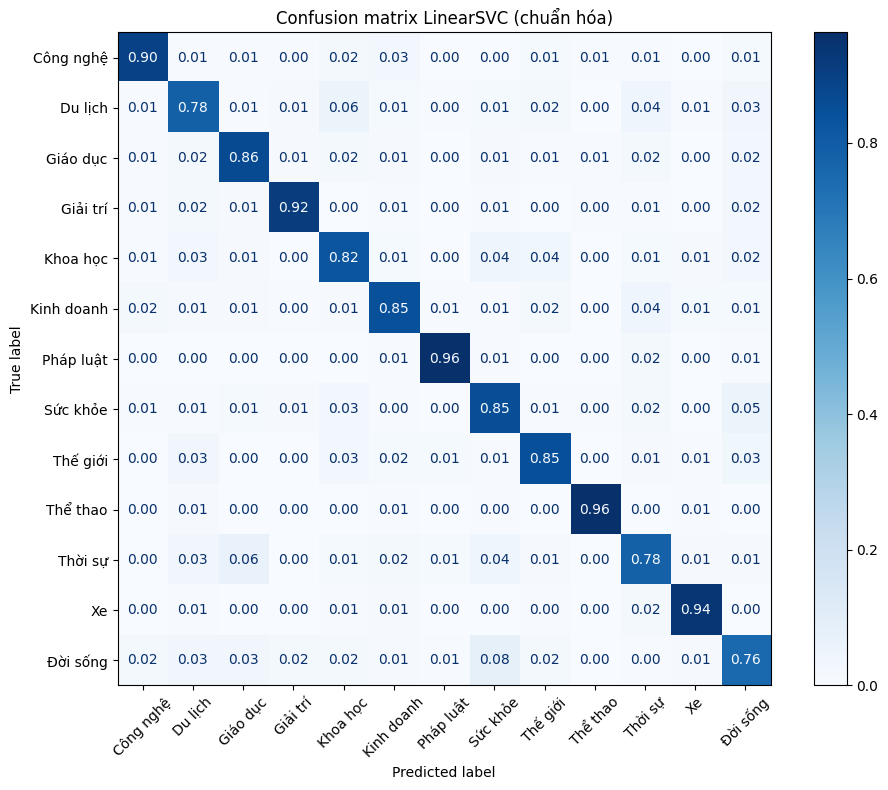

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


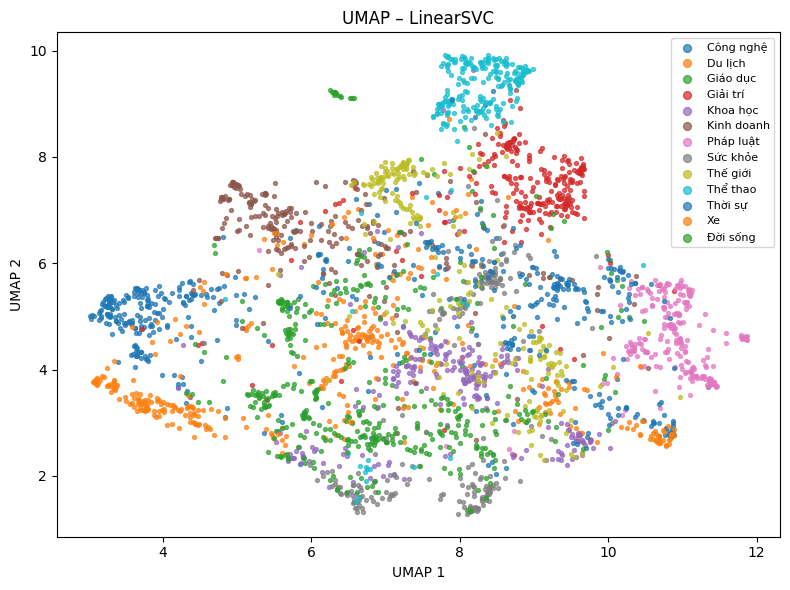

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed 

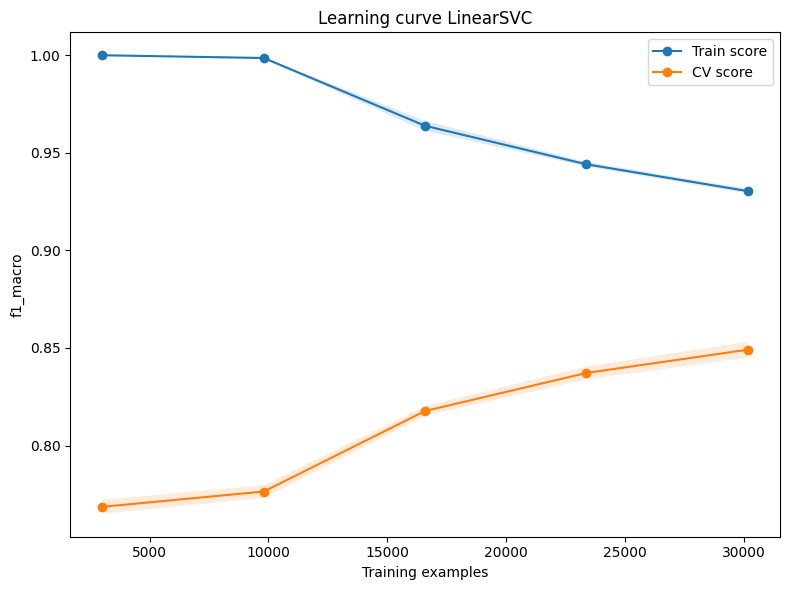

In [6]:
# ================== ĐÁNH GIÁ & TRỰC QUAN HÓA MODEL LINEAR ==================
import joblib
import numpy as np
from phobert_svm_pipeline import (    
    evaluate_confusion_matrix, plot_umap_embeddings,
    plot_learning_curve_svm
)
clf = joblib.load(f"{SAVE_MODEL_DIR}/linear_svc_phobert.joblib")

X_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_train.npy")
X_test  = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_test_emb.npy")
y_test_num  = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_test.npy")

LABEL_NAMES = [
    "Công nghệ",     # 0
    "Du lịch",       # 1
    "Giáo dục",      # 2
    "Giải trí",      # 3
    "Khoa học",      # 4
    "Kinh doanh",    # 5
    "Pháp luật",     # 6
    "Sức khỏe",      # 7
    "Thế giới",      # 8
    "Thể thao",      # 9
    "Thời sự",       # 10
    "Xe",            # 11
    "Đời sống",      # 12
]

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf,
    X_emb=X_test,
    y_true_labels=y_test_num,
    normalize=True,
    title="Confusion matrix LinearSVC",
    label_names=LABEL_NAMES
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test_num,
    label_names=LABEL_NAMES,
    max_points=3000,
    title="UMAP – LinearSVC"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro",
    title="Learning curve LinearSVC"
)

In [4]:
import numpy as np
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# =========================
# 1️⃣ Load dữ liệu
# =========================

X_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_train_emb.npy")
y_train = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_train.npy")

X_test = np.load(f"{SAVE_EMBEDDINGS_DIR}/X_test_emb.npy")
y_test = np.load(f"{SAVE_EMBEDDINGS_DIR}/y_test.npy")
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

# =========================
# 2️⃣ Pipeline: (Scaler) + SVC RBF
# =========================
clf = Pipeline([
    # Có thể bỏ scaler nếu embedding đã L2-normalized
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",          # hoặc gamma=0.01 nếu bạn đã tối ưu
        class_weight="balanced",
        random_state=42
    ))
])

# =========================
# 3️⃣ Train
# =========================
print(">> Training SVC (RBF)...")
clf.fit(X_train, y_train)

# =========================
# 4️⃣ Evaluate
# =========================
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy : {acc:.4f}")
print(f"F1-macro : {f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# =========================
# 5️⃣ Save model
# =========================
joblib.dump(clf, f"{SAVE_MODEL_DIR}/svc_rbf_phobert.joblib")
print(">> Model saved to svc_rbf_phobert.joblib")


Train shape: (37698, 768)
Test shape : (9425, 768)
>> Training SVC (RBF)...
Accuracy : 0.8864
F1-macro : 0.8863

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       730
           1       0.83      0.84      0.83       716
           2       0.88      0.88      0.88       714
           3       0.97      0.94      0.95       734
           4       0.83      0.86      0.85       733
           5       0.86      0.87      0.87       710
           6       0.97      0.97      0.97       735
           7       0.82      0.88      0.85       714
           8       0.90      0.87      0.89       733
           9       0.97      0.97      0.97       726
          10       0.83      0.78      0.80       731
          11       0.94      0.95      0.94       721
          12       0.79      0.79      0.79       728

    accuracy                           0.89      9425
   macro avg       0.89      0.89      0.89      942

In [1]:
from phobert_svm_pipeline import prepare_and_save_embeddings_v2

DATAREAL_DIR = 'dataset/data_real_full_description_clean.csv'

prepare_and_save_embeddings_v2(
    DATAREAL_DIR,
    title_col='title',
    content_col='description',
    label_col='label',
    save_dir="models/embeddings_real"
)

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>> Loading PhoBERT from local: models/phobert-base
>> Loaded 7515 samples
>> Embedding full dataset with PhoBERT...
>> Saved:
   X_emb.npy shape: (7515, 768)
   y.npy shape    : (7515,)
>> Done.


In [1]:
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

SAVE_DIR = "models/embeddings_real"

clf = joblib.load(f"models/svm/linear_svc_phobert.joblib")

X_test = np.load(f"{SAVE_DIR}/X_emb.npy")
y_test = np.load(f"{SAVE_DIR}/y.npy")

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print(f"Accuracy : {acc:.4f}")
print(f"F1-macro : {f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Accuracy : 0.6520
F1-macro : 0.6569

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       581
           1       0.62      0.68      0.65       567
           2       0.85      0.69      0.76       570
           3       0.83      0.40      0.54       573
           4       0.75      0.54      0.63       570
           5       0.73      0.54      0.62       560
           6       0.64      0.93      0.76       559
           7       0.74      0.35      0.48       576
           8       0.36      0.89      0.51       558
           9       0.96      0.87      0.91       582
          10       0.66      0.64      0.65       618
          11       0.89      0.73      0.80       585
          12       0.39      0.44      0.41       616

    accuracy                           0.65      7515
   macro avg       0.71      0.65      0.66      7515
weighted avg       0.71      0.65      0.66      7515

